# generalized factor research with specific applications to alt data

Assume a dataset is ticker tagged for 200 stocks which respond to the dataset in similar ways based on either and economic basis or investor behavior

In [1]:
import numpy as np
import pandas as pd

simulate returns and signal

In [4]:
r = 0 #avg return
r_sig = 1 #avg return conditioned on signal
sigma_alpha = 0.5 #alpha st dev
sigma_beta = 0.3 #beta st dev
rho = 0.4 #correlation between alpha and beta

#means
Mu = np.array([r, r_sig])

#covariance
Cov = np.diag([r, r_sig]) @ np.array([1, rho, rho, 1]).reshape(2,2) @ np.diag([r, r_sig])




formally we can say the alt dataset comprises an explanatory factor portfolio and the equity returns have betas to that factor. Can be exploited with superior signal construction

In [5]:
#pop equity data
m_symbols = 200

np.random.seed(60)
mvr = np.random.multivariate_normal(Mu, Cov, m_symbols)

alpha_ret = mvr[:,0]
beta_ret = mvr[:,1]

In [7]:
#train set: simulate 50 return samples for each symbol

np.random.seed(64)
n_samples = 50

event = np.random.uniform(0,1, int(n_samples * m_symbols))
sym_id = np.repeat(list(range(1, m_symbols + 1)), n_samples)
mu = alpha_ret[sym_id - 1] + beta_ret[sym_id - 1] * event
sigma = 0.5

ret = np.random.normal(mu, sigma, m_symbols * n_samples)
train_df = pd.DataFrame({'symbol' : sym_id, 'event' : event, 'ret' : ret})


In [9]:
#test set: simulate 0 return samples for each symbol 

np.random.seed(32)
n_samples = 20

event = np.random.uniform(0,1, int(n_samples * m_symbols))
sym_id = np.repeat(list(range(1, m_symbols + 1)), n_samples)
mu = alpha_ret[sym_id - 1] + beta_ret[sym_id -1] * event
sigma = 0.5

ret = np.random.normal(mu, sigma, m_symbols * n_samples)
test_df = pd.DataFrame({'symbol' : sym_id, 'event' : event, 'ret' : ret})

Now that we have a train set and a test set let's try fitting an OLS model to each equity based on only its sample of the data, individually. We'll estimate the model on the train set, then evaluate it via MSE on the test set (MSE rather than MAE because we want to penalize large errors).

We evaluate the per-symbol models ("no pooling") and average their MSEs, then evaluate out of sample on the entire dataset ("complete pooling"). 

In [12]:
import statsmodels.api as sm

symbol_mse = []
total_y = []
total_y_hat = []
rsq = []
pval = []

for symbol in train_df['symbol'].drop_duplicates().to_list():
    train_data = train_df.loc[train_df['symbol'] == symbol][['event', 'ret']].to_numpy()
    y = train_data.T[1].reshape(-1,1)
    X = sm.add_constant(train_data.T[0])
    model = sm.OLS(y, X).fit()
    rsq.append(model.rsquared)
    pval.append(model.pvalues)
    
    #evaluate model via MSE
    test_data = test_df.loc[test_df['symbol'] == symbol][['event', 'ret']].to_numpy()
    y = test_data.T[1].reshape(-1,1)
    X = sm.add_constant(test_data.T[0])
    
    y_hat = model.predict(exog=X)
    
    mse = np.square(y - y_hat).mean()
    total_y += [k for k in y]
    total_y_hat += [k for k in y_hat]
    symbol_mse.append(mse)
    
#avg of MSE across per-symbol models
print(np.mean(symbol_mse))


0.6045999327511623


In [13]:
#measure MSE across entire dataset
print(np.square(np.array(total_y) - np.array(total_y_hat)).mean())

1.2134402679058207


no pooling performs much better per-symbol than on the entire dataset

let's try complete pooling. the model estimates the alt dataset's signal across the entire sample of equities without any conditioning

In [14]:
pooled_mse = []

train_data = train_df[['event', 'ret']].to_numpy()
y = train_data.T[1].reshape(-1,1)
X = sm.add_constant(train_data.T[0])
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     1425.
Date:                Tue, 18 Mar 2025   Prob (F-statistic):          1.22e-291
Time:                        11:15:43   Log-Likelihood:                -11933.
No. Observations:               10000   AIC:                         2.387e+04
Df Residuals:                    9998   BIC:                         2.389e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0077      0.016     -0.485      0.6

In [15]:
for symbol in train_df['symbol'].drop_duplicates().to_list():
    test_data = test_df.loc[test_df['symbol'] == symbol][['event', 'ret']].to_numpy()
    y = test_data.T[1].reshape(-1,1)
    X = sm.add_constant(test_data.T[0])
    
    y_hat = model.predict(exog=X)
    
    mse = np.square(y - y_hat).mean()
    pooled_mse.append(mse)
    
print(np.mean(pooled_mse))

0.7995235612194488


In [16]:
X = sm.add_constant(test_df['event'].to_numpy())
y_hat = model.predict(X)
np.square(y-y_hat).mean()

0.46133958908871653

complete pooling performs much better on entire dataset than per-symbol

we can also fit a multilevel regression model. The fixed effects have an interpretation as the completely pooled regression coefficient and the random effects are per-symbol deviations. To make a per-symbol prediction we sum the effects. 

In [18]:
#build mixed effects model - partial pooling on symbols

import statsmodels.formula.api as smf

model = smf.mixedlm('ret ~ event', train_df, groups=train_df['symbol'])
md = model.fit()
re = {symbol: md.random_effects[symbol][0] for symbol in md.random_effects}
test_df['fe'] = md.predict(exog=test_df)
test_df['re'] = test_df['symbol'].map(re)
test_df['ret_hat'] = test_df['fe'] + test_df['re']

mse = []

for symbol in test_df['symbol'].drop_duplicates().to_list():
    test_data = test_df.loc[test_df['symbol'] == symbol]
    sym_mse = np.square(test_data['ret'] - test_data['ret_hat']).mean()
    mse.append(sym_mse)
    
print(np.mean(mse))

0.3465367586251309


this outperforms both the pooled and unpooled versions

in addition to improved out-of-sample accuracy this comes with an elegant basis for portfolio construction. The random effects have a natural interpretation as the relative out (under) performance of each symbol - neutral to the group/cluster on which the model was estimated.

So for each alt dataset with which this modeling approach works, you can simple sort by random effects in each group, long the top decile of random effects, short the bottom decile of random effects, and hedge the remainder to trade a neutral basket.

In [20]:
# Sort within each symbol group by random effects
train_df = train_df.sort_values(by=['event'])

# Define function to classify deciles
def classify_decile(group):
    group['decile'] = pd.qcut(group['event'], 10, labels=False)
    return group

# Apply the function to the DataFrame
train_df = train_df.groupby('symbol', group_keys=False).apply(classify_decile)

# Create positions
train_df['position'] = 0
train_df.loc[train_df['decile'] == 9, 'position'] = 1  # Long top decile
train_df.loc[train_df['decile'] == 0, 'position'] = -1  # Short bottom decile

# Hedge the remainder to trade a neutral basket
train_df['hedged_position'] = train_df.groupby('symbol')['position'].transform(lambda x: x - x.mean())

# Calculate the strategy returns
train_df['strategy_ret'] = train_df['hedged_position'] * train_df['ret']

# Aggregate strategy returns
strategy_returns = train_df.groupby('symbol')['strategy_ret'].sum()

# Convert to cumulative returns
strategy_returns

symbol
1       0.813416
2      10.827506
3      -5.687411
4       9.846481
5       5.026724
         ...    
196    11.671410
197     1.697227
198     1.975334
199    -0.024482
200     0.902371
Name: strategy_ret, Length: 200, dtype: float64

In [21]:
import quantstats as qs

<Axes: xlabel='symbol'>

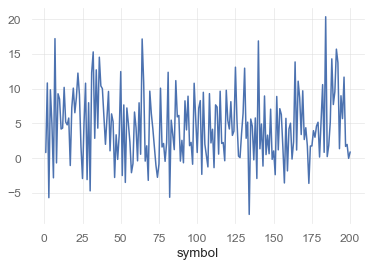

In [22]:
strategy_returns.plot()